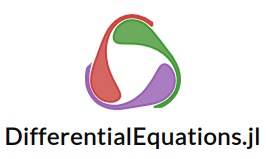

Documentation at [diffeq.sciml.ai](https://diffeq.sciml.ai/stable/) (much was copied from the documentaiton)

In [ ]:
using DifferentialEquations
using Plots

# Problem Definition

We will be solving $\frac{du}{dt} = f(u,p,t)$, a general first-order differential equations.

$u$ can be any object for which addition is defined (scalar, vector, tensor, or some other arbitrary data structure to be discussed later).

See also: [ODE examples](https://diffeq.sciml.ai/stable/tutorials/ode_example/)

We define a problem type by giving it the equation, the initial condition, and the timespan to solve over.

In [ ]:
function lorenz(u,p,t)
    du = zero(u)
    du[1] = 10.0*(u[2]-u[1])
    du[2] = u[1]*(28.0-u[3]) - u[2]
    du[3] = u[1]*u[2] - (8/3)*u[3]
    return du
end

u0 = [1.0, 0.0, 0.0] # initial conditions
tspan = (0.0, 10.0)  # time span over which to solve

# object encapsulating all information about the problem
problem = ODEProblem(lorenz, u0, tspan)

# Solution

Getting the object representing the integrated solution of the differential equation takes nothing more than calling the `solve` function.

In [ ]:
solution = solve(problem)

## Naive vs In-place problem definitions

In [ ]:
# Naively create new array each time
function lorenz(u,p,t)
    du = zero(u)
    du[1] = 10.0*(u[2]-u[1])
    du[2] = u[1]*(28.0-u[3]) - u[2]
    du[3] = u[1]*u[2] - (8/3)*u[3]
    return du
end

problem = ODEProblem(lorenz, u0, tspan)
@time solve(problem);

In [ ]:
@time solve(problem);

In [ ]:
# Reuse the old array, drastically saving time
function lorenz!(du,u,p,t)
    du[1] = 10.0*(u[2]-u[1])
    du[2] = u[1]*(28.0-u[3]) - u[2]
    du[3] = u[1]*u[2] - (8/3)*u[3]
    return du
end

problem = ODEProblem(lorenz!, u0, tspan)
@time solve(problem);

In [ ]:
@time solve(problem);

# The Solution Object

The first thing to check is whether the solver reported successful convergence.

In [ ]:
solution.retcode

We can see what were the points along the trajectory that the solver saved

In [ ]:
solution.t

In [ ]:
solution.u

The solution object provides a particularly convenient direct indexing feature:

In [ ]:
solution[3,:] # The 3rd coordinate of the entire trajectory

In [ ]:
solution[:,5] # All 3 coordinates at the 5th saved time

In [ ]:
# Convert the solution object to an array
Array(solution)

## Built-in interpolator

As you saw above, the times at which the result was saved do not look like a particularly dense grid.
The times are automatically choosen, such that they provide a sufficiently good interpolation.

For most purposes, you would want to use the `solution` object as if it was a function,
not as a sparsly populated table of solutions for various times.

In [ ]:
# Evaluate the solution of the ODE at t=0.2
solution(0.2)

### Saving at regular times

Maybe some other part of your simulation needs regular time samples.

In [ ]:
# This will specifically save at every 0.1 units of time.
# The interpolation quality would probably suffer.
solve(problem,saveat=0.1)

In [ ]:
# This will not save anything but the final result.
solve(problem,save_everystep=false)

# Built-in plotter

See also: [plotting recipies documentation](https://diffeq.sciml.ai/stable/basics/plot/)

### Naively, we can just extract the saved values

In [ ]:
plot(solution.t, Array(solution)', # We had to transpose the solution matrix 
     xlabel="Time")                # because of the format expected by plot.

### However, there are predifined methods that permit plotting from the interpolator

Plot solution vs time

In [ ]:
# Plot just the first and third coordinate vs time;
# Use an array of indices in the `vars` argument.
plot(solution, vars=[1,3])

Parametric plots

In [ ]:
# Perform a parametric plot where the time is implicit;
# Use a tuple of the indices of the vars you would like used
# as spatial coordinates.
plot(solution, vars=(2,3))

# Available Solvers

Hundreds (!?) of different solvers (see the [full list](https://diffeq.sciml.ai/stable/solvers/ode_solve/)) in a few rough categories.

That page has information on:

- Stiff vs non-stiff problems
- Low numerical tolerance vs high tolerance problems
- An excruciatingly detailed list of methods for ODE geeks

In [ ]:
solver_algo = Tsit5()
solve(problem, solver_algo, reltol=1e-8, abstol=1e-8)

# Second Order ODEs

# Stochastic Differential Equations


# Partial Differential Equations

See also: 
- [video lecture on numerical PDEs and Julia](https://www.youtube.com/watch?v=okGybBmihOE)
- [rough transcript, including code](https://nextjournal.com/sosiris-de/pde-2018)
- In particular, that lecture discusses the many ways to convert a PDE into an ODE
- The [DiffEqOperators.jl](https://github.com/SciML/DiffEqOperators.jl) package which provides a simple interface for discretization
- The [DiffEqOperators documentation](http://diffeqoperators.sciml.ai/stable/)

## Discretization example with the heat equation

The scalar PDE $$\frac{\partial u}{\partial t} = \Delta u$$
can be turned into a system of ODEs, by using a mesh (or grid) for the spatial coordinate and discretizing the spatial derivatives.

$u(t,x)$ becomes the vector $\vec{u}(t)$. The dimensionality of that vector is equal to the number of samples on the mesh (or grid).

In [ ]:
using DiffEqOperators, OrdinaryDiffEq

# Make the discretized differential operator
nknots = 100
h = 1.0/(nknots+1)
knots = range(h, step=h, length=nknots)
ord_deriv = 2
ord_approx = 2

const Δ = CenteredDifference(ord_deriv, ord_approx, h, nknots);

In [ ]:
Array(Δ)

In [ ]:
# We want to solve
# ∂ₜu = Δu

# Prepare boundary conditions
const bc = Dirichlet0BC(Float64)

# Problem definitions
step(u,p,t) = Δ*bc*u

# Initial conditions
u0 = sin.(2*π .* knots)

t0 = 0.0
t1 = 0.03
prob = ODEProblem(step, u0, (t0, t1))
sol = solve(prob);

In [ ]:
plot(sol(t0), label="at t0")
plot!(sol(t1), label="at t1")
plot!(xlabel="x")

# Function Definition Tools and DSLs

## A quick Domain Specific Language (DSL) for defining ODEs

`ParameterizedFunctions`

It is frequently more pleasant to write something that looks like your mathematical equation, not like code.

See also: [`ParameterizedFunctions` documentation](https://diffeq.sciml.ai/stable/analysis/parameterized_functions/)

In [ ]:
using ParameterizedFunctions

f = @ode_def begin
  dy₁ = -k₁*y₁+k₃*y₂*y₃
  dy₂ =  k₁*y₁-k₂*y₂^2-k₃*y₂*y₃
  dy₃ =  k₂*y₂^2
end k₁ k₂ k₃

```
function f(du,u,p,t)
  du[1] = -p[1]*u[1] + p[3]*u[2]*u[3]
  du[2] = p[1]*u[1] - p[2]*u[2]^2 - p[3]*u[2]*u[3]
  du[3] = p[2]*u[2]^2
end
```

In [ ]:
# There is quite a bit of freedom in this macro
f = @ode_def begin
  d🐁 =  α*🐁 - β*🐁*🐈
  d🐈 = -γ*🐈 + δ*🐁*🐈
end α β γ δ

## Even more sophisticated symbolic DSL

`ModelingToolkit`

Does a lot of extra stuff, like computing gradients and jacobians, and other more esoteric optimizations.

See also: 
- [Package repo](https://github.com/SciML/ModelingToolkit.jl)
- [Package docs](https://mtk.sciml.ai/stable/)
- [Arxiv preprint](https://arxiv.org/abs/2103.05244)

In [ ]:
using ModelingToolkit

@parameters t σ ρ β       # Define parameters.
@variables x(t) y(t) z(t) # Define dependent variables.
D = Differential(t)       # Define differentiation operators.

eqs = [D(D(x)) ~ σ*(y-x), # List your equations.
       D(y) ~ x*(ρ-z)-y,
       D(z) ~ x*y - β*z]

sys = ODESystem(eqs)          # Transform the list into code,
sys = ode_order_lowering(sys) # and re-express higher-order derivatives.

u0 = [D(x) => 2.0,  # Set the initial conditions,
      x => 1.0,
      y => 0.0,
      z => 0.0]

p  = [σ => 28.0,    # and set the parameter values.
      ρ => 10.0,
      β => 8/3]

# And now you have your problem, with automatic
# optimized code, including gradients and Jacobians.
tspan = (0.0,10.0)
prob = ODEProblem(sys,u0,tspan,p,jac=true)

In [ ]:
sol = solve(prob)

In [ ]:
plot(sol)

# Event Handling and Callbacks

How do we observe the solution and apply an abrubt
change dependent on the current state of the system.

See [docs on callbacks](https://diffeq.sciml.ai/stable/features/callback_functions/)

In [ ]:
# An ODE for the acceleration of a ball.
function ode_bouncingball(du,u,p,t)
  du[1] = u[2] # Derivative of speed is acceleration.
  du[2] = -p   # Acceleration in constant graviational field.
end

# The variable being tracked.
function condition(u,t,integrator) # Event when event_f(u,t) == 0
  u[1]
end

# The effect to be exerted when the condition is met.
function affect!(integrator)
  integrator.u[2] = -integrator.u[2] # "Reflect" the speed.
end

# The object that packages all this together.
cb = ContinuousCallback(condition,affect!);

In [ ]:
u0 = [50.0,0.0]
tspan = (0.0,15.0)
p = 9.8

prob = ODEProblem(ode_bouncingball,u0,tspan,p)

sol = solve(prob,callback=cb)
plot(sol)



# Sensitivity Analysis (Automatic Differentiation)

https://diffeq.sciml.ai/stable/analysis/sensitivity/
https://diffeq.sciml.ai/stable/extras/sensitivity_math/#sensitivity_math

In [ ]:
using DiffEqSensitivity, OrdinaryDiffEq, Zygote